# EDG 

Now that we have some tracking data, it is time to evaluate them. 

## Theoretical framework

We assume $s_t \in \mathcal{S}$ is the state of the game at time $t$. It may be the positions of each player and the ball for example. Given an action $a \in \mathcal{A}$ (\eg a pass, a shot,etc), and a state $s' \in \mathcal{S}$, we note $\mathbb{P} \colon \mathcal{S} \times \mathcal{A} \times \mathcal{S} \to [0,1]$ the probability $\mathbb{P} (s' \vert s, a)$ of getting to state $s'$ from $s$ following action $a$. 
%
Applying actions over $K$ time steps yields a trajectory of states and actions, $\tau ^{t_{0:K}} = \big(s_{t_0},a_{t_0}, ... ,s_{t_K},a_{t_K} \big)$. We denote $r_t$ the reward given going from $s_t$ to $s_{t+1}$ (\eg $+1$ if the team scores a goal). More importantly, the cumulative discounted reward along $\tau ^{t_{0:K}}$ is defined as:

$$R(\tau ^{t_{0:K}}) = \sum_{n=0}^{K} \gamma^{n} r_{t_n}$$

where $\gamma \in \left[0,1\right]$ is a discount factor, smoothing the impact of temporally distant rewards.

A policy, $\pi _{\theta}$, chooses the action at any given state, whose parameters, $\theta$, can be optimized for some training objectives (such as maximizing $R$). Here, a good policy would be a policy representing the team we want to analyze in the right manner. The \textit{Expected Discounted Goal} (EDG), or more generally, the state value function, is defined as:

$$V^\pi (s) = \underset{\tau \sim \pi}{\mathbb{E}} \big[ R(\tau) \vert s \big]$$

It represents the discounted expected number of goals the team will score (or concede) from a particular state. To build such a good policy, one can define an objective function based on the cumulative discounted reward:

$$J(\theta) = \underset{\tau \sim \pi_\theta}{\mathbb{E}} \big[ R(\tau) \big]$$

and seek the optimal parametrization $\theta ^*$ that maximize $J(\theta)$:

$$\theta^* = \arg \max_\theta \mathbb{E} \big[ R(\tau) \big]$$

To that end, we can compute the gradient of such cost function\footnote{Using a log probability trick, we can show that we have the following equality: $\nabla_\theta J(\theta) = \underset{\tau \sim \pi_\theta}{\mathbb{E}} \left[ \sum_{t=0}^T \nabla_\theta \log \left( \pi_\theta (a_t \vert s_t) \right) R(\tau) \right]$} $\nabla_\theta J(\theta)$ to update our parameters with $\theta \leftarrow \theta + \lambda \nabla_\theta J(\theta)$. In our case, the evaluation of $V^\pi$ and $\pi_\theta$ is done using Neural Networks, and $\theta$ represents the weights of such networks (more details on Neural Networks can be found in \citet{Goodfellow2017}). At inference, our model will take the state of the game as input, and will output the estimation of the EDG.

## Implementation 

Our EDG agent was implemented using the Google Football library. We trained our agent against bots and against itself, until it became strong enough. Such agent can be seen on this [youtube video](https://www.youtube.com/watch?v=F8DcgFDT9sc).

Let's start by importing some libraries:

**Notes**: Google Football is not compatible with Tensorflow 2 yet. We have to downgrade it to use our agent. 

In [ ]:
# !pip3 install --user tensorflow==2.11.0
# !pip3 install --user tensorflow-probability==0.19.0
# !pip3 install --user dm-sonnet==2.0.0

In [1]:
import sys
sys.path.append("./narya")
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np

Like the tracking models, our agent can easily be created: 

In [2]:
from narya.analytics.edg_agent import AgentValue
import tensorflow as tf

WEIGHTS_PATH = (
    "https://storage.googleapis.com/narya-bucket-1/models/11_vs_11_selfplay_last"
)
WEIGHTS_NAME = "11_vs_11_selfplay_last"
WEIGHTS_TOTAR = False

checkpoints = tf.keras.utils.get_file(
                WEIGHTS_NAME, WEIGHTS_PATH, WEIGHTS_TOTAR,
            )

agent = AgentValue(checkpoints = checkpoints)

2023-03-09 17:28:48.906354: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-09 17:28:49.655859: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/extras/CUPTI/lib64,/usr/local/cuda/lib64:/usr/local/cuda/lib64:
2023-03-09 17:28:49.655947: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/extras/CUPTI/lib64,/usr/local/cuda

ModuleNotFoundError: No module named 'gfootball'

## Loading and processing tracking data

First, we need to process our tracking data into a Google Football format. We built a few functions to do this.

Let's load some tracking data from Liverpool:

In [10]:
data = pd.read_csv('data/Liverpool-LastRow/liverpool_2019.csv', index_col=('play', 'frame'))
data['edgecolor'] = data['edgecolor'].fillna(0)
data.tail()

Unnamed: 0 bgcolor   dx   dy edgecolor  \
play                        frame                                           
Leicester 0 - [3] Liverpool 120          2745    blue  0.0  0.0     white   
                            121          2746    blue  0.0  0.0     white   
                            122          2747    blue  0.0  0.0     white   
                            123          2748    blue  0.0  0.0     white   
                            124          2749    blue  0.0  0.0     white   

                                   player  player_num     team          x  \
play                        frame                                           
Leicester 0 - [3] Liverpool 120     10267         NaN  defense  98.724826   
                            121     10267         NaN  defense  98.724826   
                            122     10267         NaN  defense  98.724826   
                            123     10267         NaN  defense  98.724826   
                            124     10267         NaN  defense  98.724826   

                                           y    z  
play                        frame                  
Leicester 0 - [3] Liverpool 120    53.720353  0.0  
                            121    53.720353  0.0  
                            122    53.720353  0.0  
                            123    53.720353  0.0  
                            124    53.720353  0.0

Let's process them to add some features: 

In [11]:
from narya.utils.google_football_utils import _add_ball_coordinates, _add_possession

In [12]:
data = data.rename(columns={'edgecolor':'id'})
data_test = _add_ball_coordinates(data,id_ball=0)
data_test = _add_possession(data_test)
data_test = data_test.rename(columns={'id':'edgecolor'})

We can chose one game, and display the first frame:

In [13]:
play =  'Leicester 0 - [3] Liverpool'
df = data_test[data_test['play'] == play]
df = df.set_index('frame')
df['bgcolor'] = df['bgcolor'].fillna('black')
df.tail()

,bgcolor,dx,dy,edgecolor,player,player_num,team,x,y,z,ball_x,ball_y,ball_z,play,possession
frame,,,,,,,,,,,,,,,
120,blue,0.0,0.0,white,10267,NaN,defense,98.724826,53.720353,0.0,100.680272,44.957983,0.0,Leicester 0 - [3] Liverpool,False
121,blue,0.0,0.0,white,10267,NaN,defense,98.724826,53.720353,0.0,100.680272,44.957983,0.0,Leicester 0 - [3] Liverpool,False
122,blue,0.0,0.0,white,10267,NaN,defense,98.724826,53.720353,0.0,100.680272,44.957983,0.0,Leicester 0 - [3] Liverpool,False
123,blue,0.0,0.0,white,10267,NaN,defense,98.724826,53.720353,0.0,100.680272,44.957983,0.0,Leicester 0 - [3] Liverpool,False
124,blue,0.0,0.0,white,10267,NaN,defense,98.724826,53.720353,0.0,100.680272,44.957983,0.0,Leicester 0 - [3] Liverpool,False


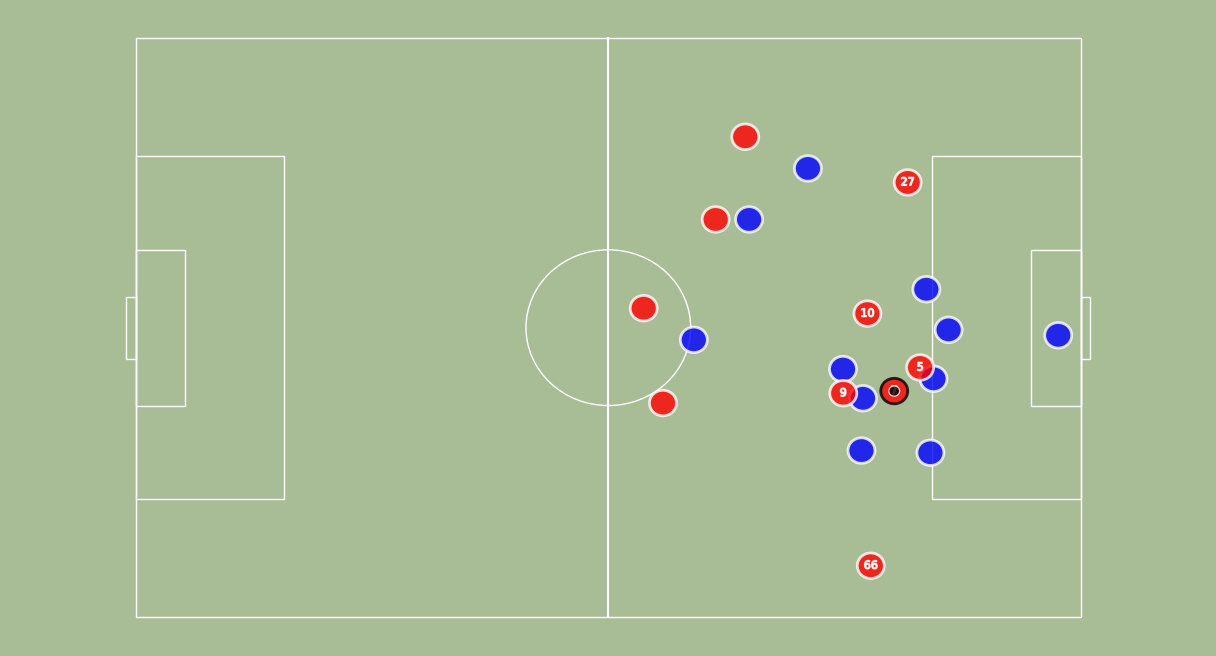

In [14]:
from narya.utils.vizualization import draw_frame

fig, ax, dfFrame = draw_frame(df,t=0,add_vector = False,fps=20)

We can also add a Voronoi Diagram and velocity vectors on our field: 

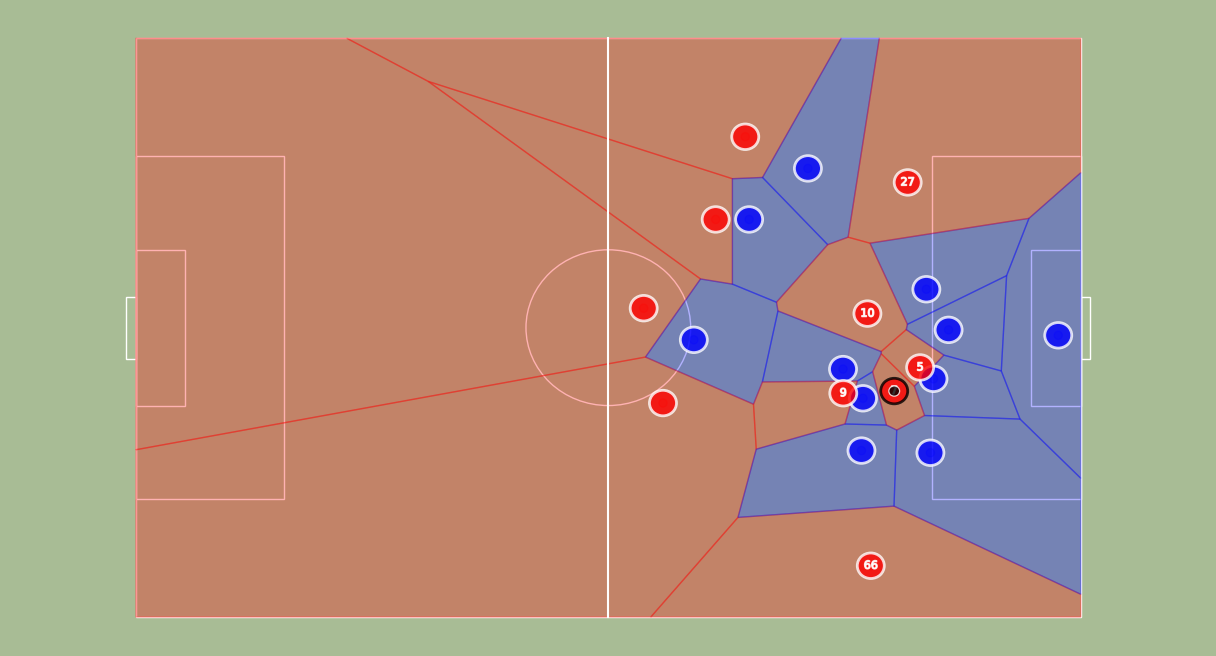

In [15]:
from narya.utils.vizualization import add_voronoi_to_fig

fig, ax, dfFrame = draw_frame(df,t=0,fps=20)
fig, ax, dfFrame = add_voronoi_to_fig(fig, ax, dfFrame)

## Google Format

We now have to change our data into a google format. To do so, we need to change:

* the Ball positions and velocity
* the Players positions and velocity 
* Who owns the ball, and what team he is in 

and transfer the coordinates in a different representation. 

In [17]:
from narya.utils.google_football_utils import _save_data, _build_obs_stacked

data_google = _save_data(df,'test_temo.dump')

In [18]:
observations = {
    'frame_count':[],
    'obs':[],
    'obs_count':[],
    'value':[]
}

for i in range(len(data_google)):
    obs,obs_count = _build_obs_stacked(data_google,i)
    observations['frame_count'].append(i)
    observations['obs'].append(obs)
    observations['obs_count'].append(obs_count)

We can now plot an EDG map at $t=1$. It represents the location with the most potential on the field. 

In [19]:
np.argwhere(observations['obs'][20][:,:,2] > 0.)

array([[57, 79]])

In [20]:
map_value = agent.get_edg_map(observations['obs'][20],observations['obs_count'][20],79,57,entity = 'ball')

NameError: name 'agent' is not defined

NameError: name 'map_value' is not defined

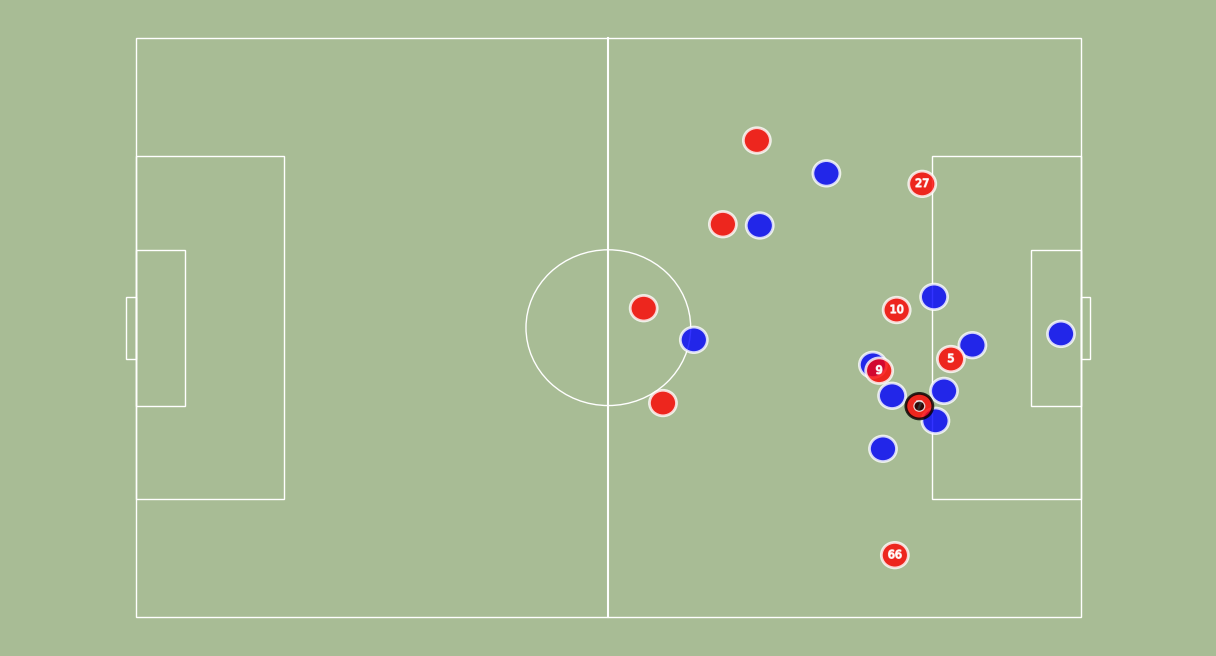

In [21]:
from narya.utils.vizualization import add_edg_to_fig

fig, ax, dfFrame = draw_frame(df, t=1)
fig, ax, edg_map = add_edg_to_fig(fig, ax, map_value)

You can also plot the EDG value over time: 

In [22]:
from narya.utils.vizualization import draw_line

for indx,obs in enumerate(observations['obs']):
    value = agent.get_value([obs])
    observations['value'].append(value)
df_dict = {
    'frame_count':observations['frame_count'],
    'value':observations['value']
}
df_ = pd.DataFrame(df_dict)
fig, ax = draw_line(df_,1,20, smooth=True)


NameError: name 'agent' is not defined